##### Imports

In [8]:
import glob

from osgeo import gdal

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")

In [4]:
(data_dir/"train").ls()

[PosixPath('/media/wwymak/Storage/xView2/train/images'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels')]

In [6]:
(data_dir/"train"/"images").ls()[:10]

[PosixPath('/media/wwymak/Storage/xView2/train/images/palu-tsunami_00000024_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-matthew_00000005_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-florence_00000392_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000669_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/midwest-flooding_00000085_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000748_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000905_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/palu-tsunami_00000101_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000923_pre_disaster.png')]

In [7]:
(data_dir/"train"/"labels").ls()[:10]

[PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000521_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-michael_00000047_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00001003_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000580_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000671_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-michael_00000348_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-matthew_00000119_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-harvey_00000333_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-michael_00000485_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-florence_00000245_post_disaster.json')]

In [13]:
with open('/media/wwymak/Storage/xView2/train/labels/hurricane-florence_00000245_post_disaster.json', 'r') as f:
    test_label = json.load(f)

In [14]:
test_label

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
     'subtype': 'minor-damage',
     'uid': '14bd997f-cc0b-4683-8a23-2134f861fc35'},
    'wkt': 'POLYGON ((-77.95409509313248 34.71221630738264, -77.95405212352033 34.71226295449415, -77.95356092670308 34.71206554576935, -77.95358117713972 34.71202458193781, -77.95359602114189 34.71202557764552, -77.95360575761758 34.7120109778237, -77.95361450570638 34.71199045186941, -77.95360488299279 34.71198491007996, -77.9536255453871 34.71195624007157, -77.95411745653439 34.71215547151242, -77.95409509313248 34.71221630738264))'},
   {'properties': {'feature_type': 'building',
     'subtype': 'minor-damage',
     'uid': 'c20ace52-1121-469c-b8d8-ba0f8666175f'},
    'wkt': 'POLYGON ((-77.95682887876849 34.71178094637379, -77.9567561789528 34.71176792448772, -77.95676871693382 34.7117130018231, -77.95673767717523 34.71170405303792, -77.95674863422425 34.71165819873173, -77.95677972512121 34.71166202442159, -77.95680027713586 34.7

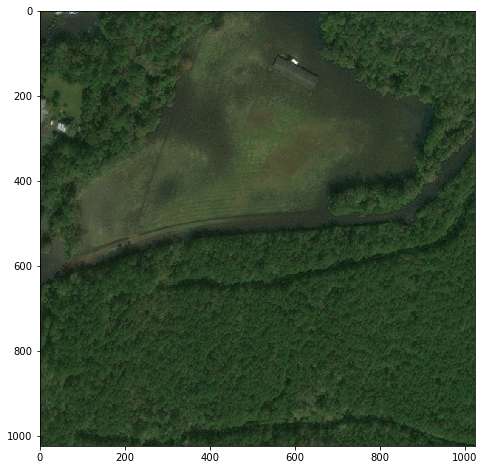

In [17]:
plt.figure(figsize=(8,8))
img = np.array(PIL.Image.open(data_dir/"train"/"images"/"hurricane-florence_00000245_post_disaster.png"))
plt.imshow(img)

In [21]:
test_label['features'].keys()

dict_keys(['lng_lat', 'xy'])

The xy field have the polygons in pixels

In [22]:
test_label['features']['xy']

[{'properties': {'feature_type': 'building',
   'subtype': 'minor-damage',
   'uid': '14bd997f-cc0b-4683-8a23-2134f861fc35'},
  'wkt': 'POLYGON ((551.3078704179859 117.1714860541048, 560.257317210967 106.0970249230621, 657.3470139054577 156.9295214274333, 652.9939740193912 166.7577664150858, 650.0244479855587 166.4285135401068, 647.9678479814745 169.9165327214746, 646.0671633329048 174.8494625075223, 647.9572422633735 176.2519123039099, 643.6093020129714 183.0923268614152, 546.3892649409751 131.8129372805153, 551.3078704179859 117.1714860541048))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'minor-damage',
   'uid': 'c20ace52-1121-469c-b8d8-ba0f8666175f'},
  'wkt': 'POLYGON ((-9.624120495094025e-06 206.7764224383476, 14.48534958151996 210.3674244078077, 11.57884068398977 223.6307710949835, 17.73927836843852 225.9869493896641, 15.21456348114892 237.0574810245938, 9.00727567304877 235.9450815513466, 4.133685141409885 261.4017060562214, -9.623610864418334e-06 261.58058935

whereas the lng_lat field has the polygons in geocoords

In [23]:
test_label['features']['lng_lat']

[{'properties': {'feature_type': 'building',
   'subtype': 'minor-damage',
   'uid': '14bd997f-cc0b-4683-8a23-2134f861fc35'},
  'wkt': 'POLYGON ((-77.95409509313248 34.71221630738264, -77.95405212352033 34.71226295449415, -77.95356092670308 34.71206554576935, -77.95358117713972 34.71202458193781, -77.95359602114189 34.71202557764552, -77.95360575761758 34.7120109778237, -77.95361450570638 34.71199045186941, -77.95360488299279 34.71198491007996, -77.9536255453871 34.71195624007157, -77.95411745653439 34.71215547151242, -77.95409509313248 34.71221630738264))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'minor-damage',
   'uid': 'c20ace52-1121-469c-b8d8-ba0f8666175f'},
  'wkt': 'POLYGON ((-77.95682887876849 34.71178094637379, -77.9567561789528 34.71176792448772, -77.95676871693382 34.7117130018231, -77.95673767717523 34.71170405303792, -77.95674863422425 34.71165819873173, -77.95677972512121 34.71166202442159, -77.95680027713586 34.71155669548423, -77.95682084707019 34.71

In [27]:
def parse_json(label_json):
    df_xy =  pd.DataFrame([{'id':x['properties']['uid'], 'feature':x['properties']['feature_type'],
      'damage':x['properties']['subtype'],'geom':x['wkt'],} for x in label_json['features']['xy']])
    df_lnglat = pd.DataFrame([{'id':x['properties']['uid'], 'feature':x['properties']['feature_type'],
      'damage':x['properties']['subtype'],'geom':x['wkt'],} for x in label_json['features']['lng_lat']])
    df_xy.set_index('id', inplace=True)
    df_lnglat.set_index('id', inplace=True)
    
    return df_xy.merge(df_lnglat['geom'], left_index=True, right_index=True)

In [28]:
parse_json(test_label)

,feature,damage,geom_x,geom_y
id,,,,
14bd997f-cc0b-4683-8a23-2134f861fc35,building,minor-damage,"POLYGON ((551.3078704179859 117.1714860541048,...",POLYGON ((-77.95409509313248 34.71221630738264...
c20ace52-1121-469c-b8d8-ba0f8666175f,building,minor-damage,POLYGON ((-9.624120495094025e-06 206.776422438...,POLYGON ((-77.95682887876849 34.71178094637379...
c5615af1-29f3-47b1-9e3a-0e13f5defce2,building,no-damage,"POLYGON ((41.34408419521144 263.1020550089976,...",POLYGON ((-77.95661462698502 34.71155420251669...
2ca788e1-0369-4649-9230-91b6d5cb2426,building,minor-damage,POLYGON ((54.51347043995949 0.0064060840942350...,POLYGON ((-77.95658756510389 34.71263828125383...


In [ ]:
fp_mask = sol.vector.mask.footprint_mask(df=parse_json(test_label),)
f, ax = plt.subplots(figsize=(10, 10))
plt.imshow(fp_mask, cmap='gray')